In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import time

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize()

import shap
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
train_app = pd.read_pickle('after_EDA/train_app.pkl')
train_sms = pd.read_pickle('after_EDA/train_sms.pkl')
train_user = pd.read_pickle('after_EDA/train_user.pkl')
train_voc = pd.read_pickle('after_EDA/train_voc.pkl')

test_app = pd.read_pickle('after_EDA/test_app.pkl')
test_sms = pd.read_pickle('after_EDA/test_sms.pkl')
test_user = pd.read_pickle('after_EDA/test_user.pkl')
test_voc = pd.read_pickle('after_EDA/test_voc.pkl')



In [ ]:
'''
    以下是baseline
    
    
    
'''

In [40]:
combine_train = train_user[['phone_no_m', 'label','city_name', 'county_name', 'idcard_cnt', 'is_arrears','mean_arpu']]
combine_test = test_user[['phone_no_m', 'city_name', 'county_name', 'idcard_cnt', 'is_arrears','mean_arpu']]

# merge app
combine_train = pd.merge(combine_train,train_app.groupby('phone_no_m').mean()['flow'].reset_index(),on='phone_no_m',how='inner')
combine_test = pd.merge(combine_test,test_app.groupby('phone_no_m').mean()['flow'].reset_index(),on='phone_no_m',how='inner')

# merge sms
a = train_sms.groupby(['phone_no_m','sms_calltype_id']).count().reset_index()
a = a.pivot(index='phone_no_m',columns='sms_calltype_id',values = 'opposite_no_m')

b = test_sms.groupby(['phone_no_m','sms_calltype_id']).count().reset_index()
b = b.pivot(index='phone_no_m',columns='sms_calltype_id',values = 'opposite_no_m')

combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_test = pd.merge(combine_test,b,on='phone_no_m',how='left')

combine_train.rename(columns={1:'num_active_sms',2:'num_pass_sms'},inplace=True)
combine_test.rename(columns={1:'num_active_sms',2:'num_pass_sms'},inplace=True)


# merge voc
a = train_voc.groupby(['phone_no_m','voice_calltype_id']).count().reset_index()
a = a.pivot(index='phone_no_m',columns='voice_calltype_id',values = ['opposite_no_m','call_dur'])

b = test_voc.groupby(['phone_no_m','voice_calltype_id']).count().reset_index()
b = b.pivot(index='phone_no_m',columns='voice_calltype_id',values = ['opposite_no_m','call_dur'])

combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_test = pd.merge(combine_test,b,on='phone_no_m',how='left')

combine_train.rename(columns={('opposite_no_m', 'active_call'):'num_active_call',('opposite_no_m', 'passive_call'):'num_pass_call',
                              ('opposite_no_m', 'call_forward'):'num_call_forward',('call_dur', 'active_call'):'dur_active_call',
                             ('call_dur', 'passive_call'):'dur_pass_call',('call_dur', 'call_forward'):'dur_call_forward'},inplace=True)
combine_test.rename(columns={('opposite_no_m', 'active_call'):'num_active_call',('opposite_no_m', 'passive_call'):'num_pass_call',
                              ('opposite_no_m', 'call_forward'):'num_call_forward',('call_dur', 'active_call'):'dur_active_call',
                             ('call_dur', 'passive_call'):'dur_pass_call',('call_dur', 'call_forward'):'dur_call_forward'},inplace=True)




In [41]:
y = combine_train['label']
combine_train.drop(columns=['label','phone_no_m'],inplace=True)
combine_test.drop(columns='phone_no_m',inplace=True)

---------
ROC Score:  0.8514174331259142
f1-score-macro:  0.8533813263525305


<Figure size 864x432 with 0 Axes>

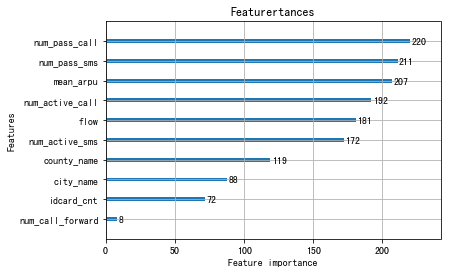

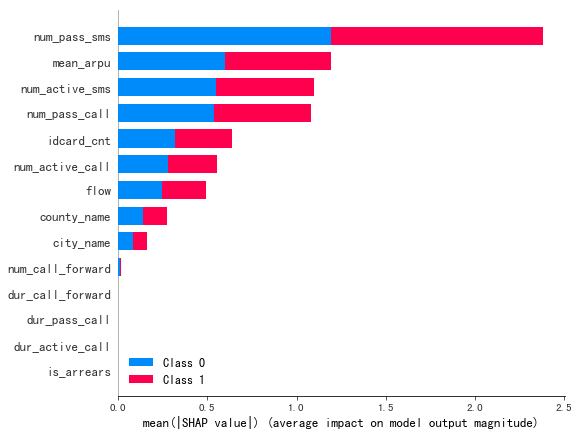

---------
ROC Score:  0.87610250711855
f1-score-macro:  0.872192538432696


<Figure size 864x432 with 0 Axes>

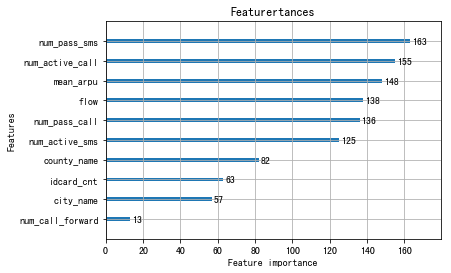

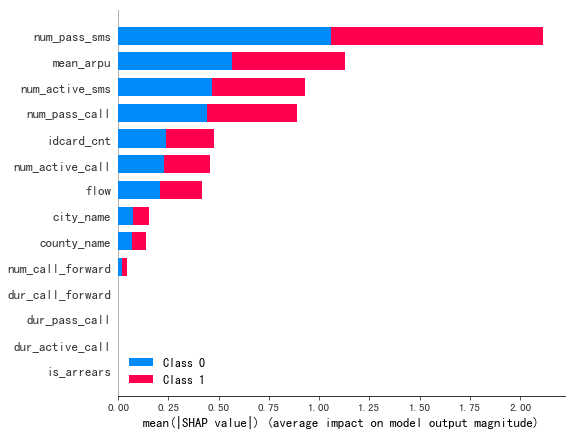

---------
ROC Score:  0.8583943554772617
f1-score-macro:  0.8639002887976897


<Figure size 864x432 with 0 Axes>

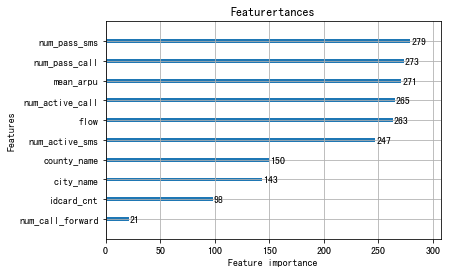

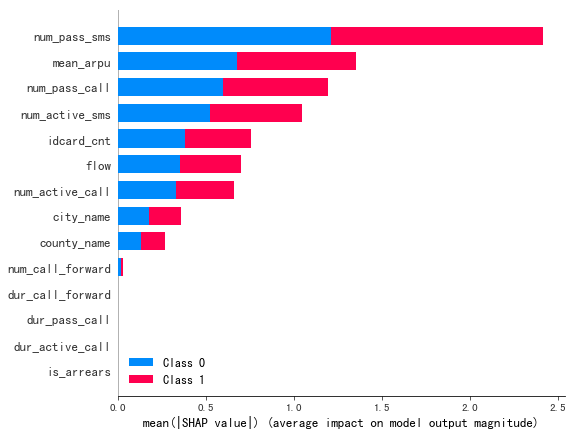

---------
ROC Score:  0.8850563122459744
f1-score-macro:  0.885324615144593


<Figure size 864x432 with 0 Axes>

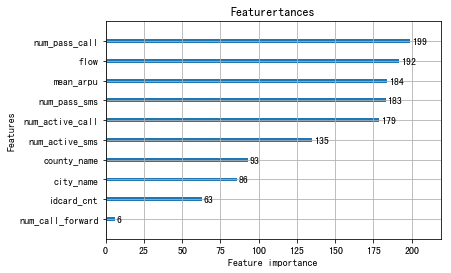

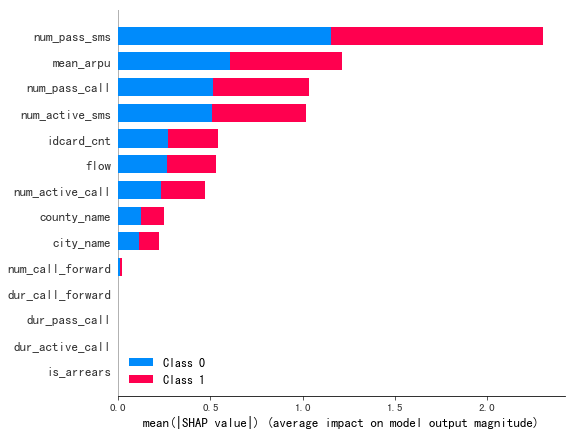

---------
ROC Score:  0.8705283262846332
f1-score-macro:  0.8732249180386646


<Figure size 864x432 with 0 Axes>

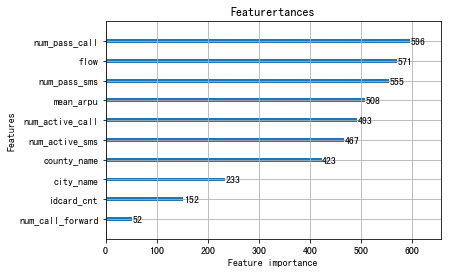

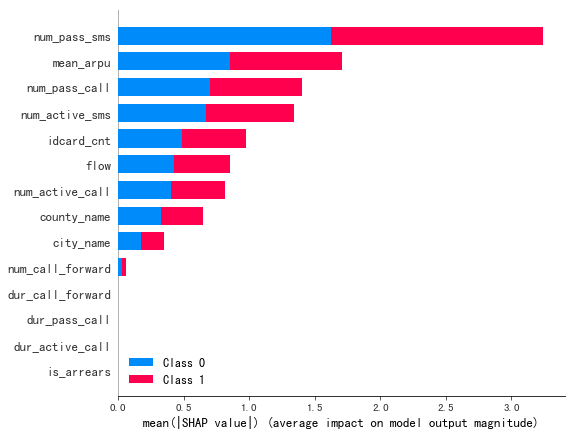

avg +++++++++++++++++++++++++++
ROC Score:  0.0
f1-score-macro:  0.0
tn:  0.0
fp:  0.0
fn:  0.0
tp:  0.0
precision:  0.0
recall:  0.0


In [43]:
'''
    baseline

'''
def score_trans(y):
    res = []
    for x in y:
        if x < 0.5:
            res.append(0)
        else:
            res.append(1)
    return res


category_feature = []
for x in combine_train.select_dtypes(include='object').columns:
    combine_train[x] = combine_train[x].astype('category')
    category_feature.append(x)

# gbm = lgb.LGBMClassifier(objective='binary',is_unbalance=True)

params = {'objective':'binary',
         'is_unbalance':True,
        'metric':'auc'}
    
    
# X_train, X_test, y_train, y_test = train_test_split(combine_train,y,shuffle=True)

roc,f1_scoret,tnt,fpt,fnt,tpt,precisiont,recallt=0,0,0,0,0,0,0,0

kf = KFold(n_splits=5,shuffle=True)
for train_idx,test_idx in kf.split(combine_train):
    X_train,X_test = combine_train.loc[train_idx],combine_train.loc[test_idx]
    y_train,y_test = y[train_idx],y[test_idx]
    
#     gbm.fit(X_train,y_train)
#     y_pred = gbm.predict(X_test)
    
    trains = lgb.Dataset(X_train,label=y_train,categorical_feature=category_feature,silent=True)
    tests = lgb.Dataset(X_test,label=y_test,categorical_feature=category_feature,silent=True)
    
    gbm = lgb.train(params,trains,num_boost_round=200,valid_sets=[tests],early_stopping_rounds=100,verbose_eval=False)
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    
    y_pred = score_trans(y_pred)
    
    # 乘上一个比例，以确定0.45-0.55之间的为
    print('---------')
    print('ROC Score: ',roc_auc_score(y_test,y_pred))
    print('f1-score-macro: ',f1_score(y_test,y_pred,average='macro'))
    
    
    
#     tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
#     print('tn: ',tn)
#     print('fp: ',fp)
#     print('fn: ',fn)
#     print('tp: ',tp)
#     print('precision: ',tp/(tp+fp))
#     print('recall: ',tp/(tp+fn))
    
#     roc += roc_auc_score(y_test,y_pred)
#     f1_scoret += f1_score(y_test,y_pred,average='macro')
#     tnt += tn
#     fpt += fp
#     fnt += fn
#     tpt += tp
#     precisiont += tp/(tp+fp)
#     recallt += tp/(tp+fn)
    
    plt.figure(figsize=(12,6))
    lgb.plot_importance(gbm, max_num_features=30)
    plt.title("Featurertances")
    plt.show()
    
    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer.shap_values(combine_train)
    shap.summary_plot(shap_values, combine_train)

print('avg +++++++++++++++++++++++++++')
print('ROC Score: ',roc/5)
print('f1-score-macro: ',f1_scoret/5)


print('tn: ',tnt/5)
print('fp: ',fpt/5)
print('fn: ',fnt/5)
print('tp: ',tpt/5)
print('precision: ',precisiont/5)
print('recall: ',recallt/5)



In [162]:
pred = gbm.predict(combine_test)
test_user['label'] = pred

In [171]:
test_user[['phone_no_m','label']].to_csv('baseline.csv',index=None)

In [140]:
del a,b
gc.collect()

3593

In [207]:
'''

    第一次改，基于baseline， baseline 线上0.65左右

'''

'\n\n    第一次改，基于baseline， baseline 线上0.65左右\n\n'

In [6]:
combine_train = train_user[['phone_no_m', 'label','city_name', 'county_name', 'idcard_cnt', 'is_arrears','is_null','mean_arpu']]
combine_test = test_user[['phone_no_m', 'city_name', 'county_name', 'idcard_cnt','is_null', 'is_arrears','mean_arpu']]

# merge app
combine_train = pd.merge(combine_train,train_app.groupby('phone_no_m').mean()['flow'].reset_index(),on='phone_no_m',how='inner')
combine_test = pd.merge(combine_test,test_app.groupby('phone_no_m').mean()['flow'].reset_index(),on='phone_no_m',how='inner')

# merge sms
a = train_sms.groupby(['phone_no_m','sms_calltype_id']).count().reset_index()
a = a.pivot(index='phone_no_m',columns='sms_calltype_id',values = 'opposite_no_m')

b = test_sms.groupby(['phone_no_m','sms_calltype_id']).count().reset_index()
b = b.pivot(index='phone_no_m',columns='sms_calltype_id',values = 'opposite_no_m')

combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_test = pd.merge(combine_test,b,on='phone_no_m',how='left')

combine_train.rename(columns={1:'num_active_sms',2:'num_pass_sms'},inplace=True)
combine_test.rename(columns={1:'num_active_sms',2:'num_pass_sms'},inplace=True)


# merge voc
a = train_voc.groupby(['phone_no_m','voice_calltype_id']).count().reset_index()
a = a.pivot(index='phone_no_m',columns='voice_calltype_id',values = ['opposite_no_m','call_dur'])

b = test_voc.groupby(['phone_no_m','voice_calltype_id']).count().reset_index()
b = b.pivot(index='phone_no_m',columns='voice_calltype_id',values = ['opposite_no_m','call_dur'])

combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_test = pd.merge(combine_test,b,on='phone_no_m',how='left')

combine_train.rename(columns={('opposite_no_m', 'active_call'):'num_active_call',('opposite_no_m', 'passive_call'):'num_pass_call',
                              ('opposite_no_m', 'call_forward'):'num_call_forward',('call_dur', 'active_call'):'dur_active_call',
                             ('call_dur', 'passive_call'):'dur_pass_call',('call_dur', 'call_forward'):'dur_call_forward'},inplace=True)
combine_test.rename(columns={('opposite_no_m', 'active_call'):'num_active_call',('opposite_no_m', 'passive_call'):'num_pass_call',
                              ('opposite_no_m', 'call_forward'):'num_call_forward',('call_dur', 'active_call'):'dur_active_call',
                             ('call_dur', 'passive_call'):'dur_pass_call',('call_dur', 'call_forward'):'dur_call_forward'},inplace=True)




In [237]:
# 1. test 数据中，话费有空，而train里面，用的是平均话费所以没有空，要弄一下  
#               ---------> 添加了user.is_null，表示是否有空的话费，线上评分 from 0.65 ----> 0.73
# 话费波动也是一个点，但是测试集只有一个月的话费


In [7]:
# 2. 价格 max 话费 try    
#          -------------> 添加max_arpu  线上 from 0.73 ----> 0.75
#          -------------> 去掉mean_arpu  线上 from 0.75 ----> 0.77
combine_train['max_arpu'] = train_user[['arpu_201908','arpu_201909','arpu_201910','arpu_201911']].max(axis=1)
combine_test['max_arpu'] = combine_test['mean_arpu'] 
combine_train.drop(columns='mean_arpu',inplace=True)
combine_test.drop(columns='mean_arpu',inplace=True)
# test 只有一个月的

In [8]:
# 3. 删除is_arrers  从shap图上看没什么用，线上 from 0.77 -----> 0.8
combine_train.drop(columns=['is_arrears'],inplace=True)
combine_test.drop(columns=['is_arrears'],inplace=True)

In [9]:
# 4. 去掉county_name 可能有奇效
combine_train.drop(columns=['county_name'],inplace=True)
combine_test.drop(columns=['county_name'],inplace=True)

In [273]:
combine_train

,city_name,county_name,idcard_cnt,is_arrears,is_null,flow,num_active_sms,num_pass_sms,num_active_call,num_pass_call,num_call_forward,dur_active_call,dur_pass_call,dur_call_forward,max_arpu
0,绵阳,江油分公司,1,0,0,13.758107,6.0,1410.0,649.0,609.0,NaN,649.0,609.0,NaN,46.062500
1,德阳,旌阳分公司,1,0,0,30.455729,25.0,4217.0,43.0,113.0,NaN,43.0,113.0,NaN,79.312500
2,成都,金堂分公司,2,0,0,14.853838,97.0,1278.0,779.0,373.0,NaN,779.0,373.0,NaN,24.453125
3,成都,高新分公司,2,0,0,1.736553,48.0,4322.0,1457.0,3149.0,477.0,1457.0,3149.0,477.0,173.125000
4,德阳,旌阳分公司,1,0,0,43.785896,1.0,722.0,19.0,42.0,NaN,19.0,42.0,NaN,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,宜宾,高县分公司,1,0,0,66.458191,71.0,1288.0,71.0,1.0,NaN,71.0,1.0,NaN,2.500000
6102,天府新区,直管区,4,0,1,0.865110,14368.0,403.0,161.0,1.0,NaN,161.0,1.0,NaN,5.238281
6103,未知,未知,4,0,1,0.006281,NaN,21.0,236.0,9.0,NaN,236.0,9.0,NaN,NaN
6104,绵阳,三台分公司,3,0,0,114.149414,11.0,2151.0,1063.0,420.0,NaN,1063.0,420.0,NaN,272.500000


In [10]:
y = combine_train['label']
combine_train.drop(columns=['label','phone_no_m'],inplace=True)
combine_test.drop(columns='phone_no_m',inplace=True)

---------
ROC Score:  0.8561528059499661
f1-score-macro:  0.8554919085441406


<Figure size 864x432 with 0 Axes>

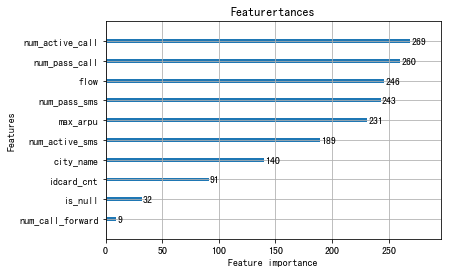

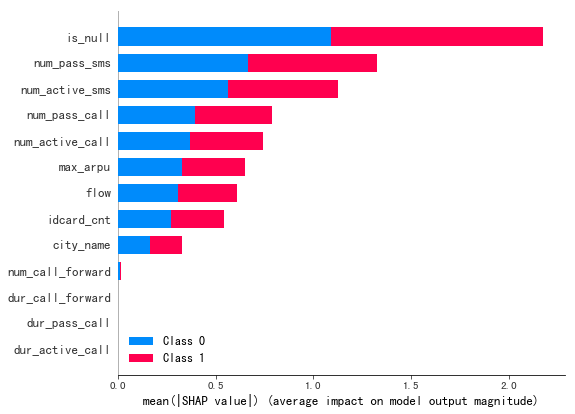

---------
ROC Score:  0.8724859778710883
f1-score-macro:  0.8761917293960563


<Figure size 864x432 with 0 Axes>

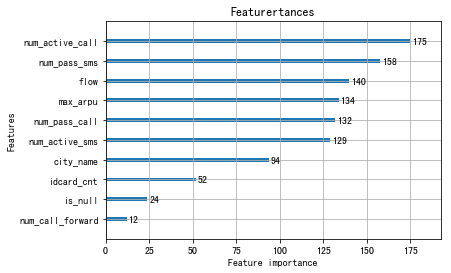

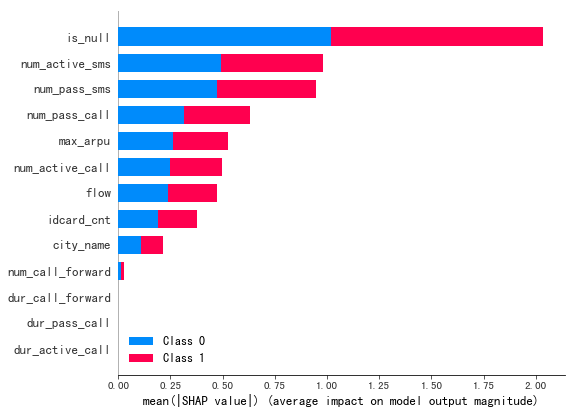

---------
ROC Score:  0.8599221972253468
f1-score-macro:  0.8570919212455732


<Figure size 864x432 with 0 Axes>

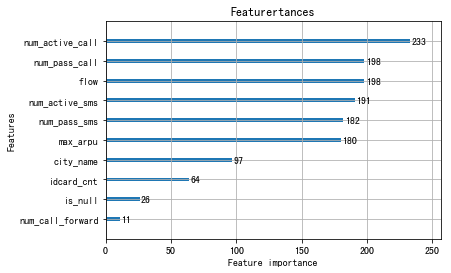

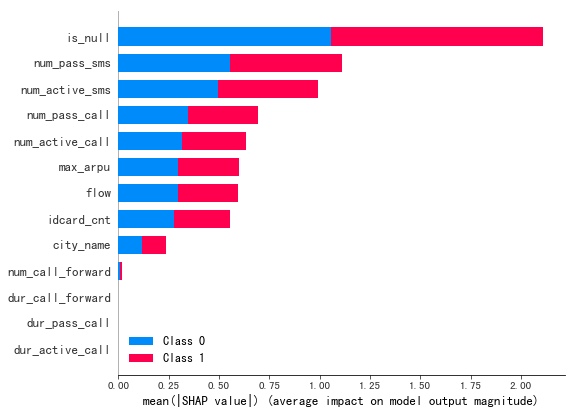

---------
ROC Score:  0.8801805714994881
f1-score-macro:  0.8841742157273951


<Figure size 864x432 with 0 Axes>

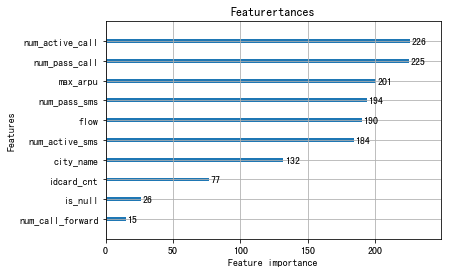

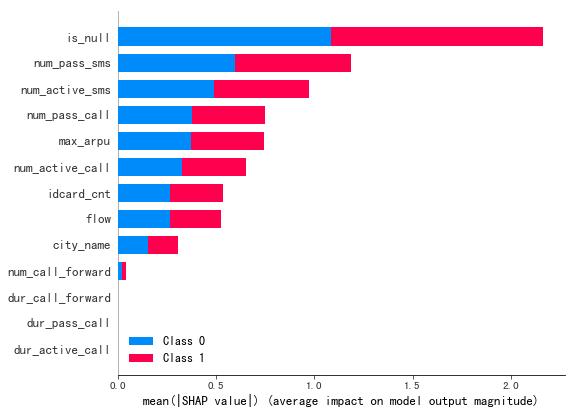

---------
ROC Score:  0.8678223534394393
f1-score-macro:  0.8727365218040621


<Figure size 864x432 with 0 Axes>

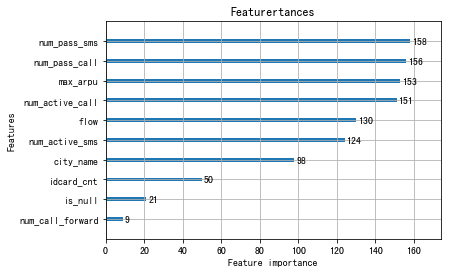

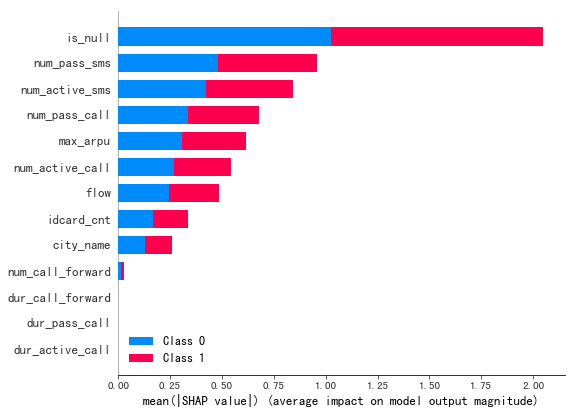

In [39]:
'''
    与下面的每次都有一个对比用哪个

'''
def score_trans(y):
    res = []
    for x in y:
        if x < 0.5:
            res.append(0)
        else:
            res.append(1)
    return res


category_feature = []
for x in combine_train.select_dtypes(include='object').columns:
    combine_train[x] = combine_train[x].astype('category')
    category_feature.append(x)

# gbm = lgb.LGBMClassifier(objective='binary',is_unbalance=True)

params = {'objective':'binary',
         'is_unbalance':True,
        'metric':'auc'}
    
    
# X_train, X_test, y_train, y_test = train_test_split(combine_train,y,shuffle=True)

roc,f1_scoret,tnt,fpt,fnt,tpt,precisiont,recallt=0,0,0,0,0,0,0,0

kf = KFold(n_splits=5,shuffle=True)
for train_idx,test_idx in kf.split(combine_train):
    X_train,X_test = combine_train.loc[train_idx],combine_train.loc[test_idx]
    y_train,y_test = y[train_idx],y[test_idx]
    
#     gbm.fit(X_train,y_train)
#     y_pred = gbm.predict(X_test)
    
    trains = lgb.Dataset(X_train,label=y_train,categorical_feature=category_feature,silent=True)
    tests = lgb.Dataset(X_test,label=y_test,categorical_feature=category_feature,silent=True)
    
    gbm = lgb.train(params,trains,num_boost_round=200,valid_sets=[tests],early_stopping_rounds=100,verbose_eval=False)
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    
    y_pred = score_trans(y_pred)
    
    # 乘上一个比例，以确定0.45-0.55之间的为
    print('---------')
    print('ROC Score: ',roc_auc_score(y_test,y_pred))
    print('f1-score-macro: ',f1_score(y_test,y_pred,average='macro'))
    
    
    
#     tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
#     print('tn: ',tn)
#     print('fp: ',fp)
#     print('fn: ',fn)
#     print('tp: ',tp)
#     print('precision: ',tp/(tp+fp))
#     print('recall: ',tp/(tp+fn))
    
#     roc += roc_auc_score(y_test,y_pred)
#     f1_scoret += f1_score(y_test,y_pred,average='macro')
#     tnt += tn
#     fpt += fp
#     fnt += fn
#     tpt += tp
#     precisiont += tp/(tp+fp)
#     recallt += tp/(tp+fn)
    
    plt.figure(figsize=(12,6))
    lgb.plot_importance(gbm, max_num_features=30)
    plt.title("Featurertances")
    plt.show()
    
    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer.shap_values(combine_train)
    shap.summary_plot(shap_values, combine_train)

# print('avg +++++++++++++++++++++++++++')
# print('ROC Score: ',roc/5)
# print('f1-score-macro: ',f1_scoret/5)


# print('tn: ',tnt/5)
# print('fp: ',fpt/5)
# print('fn: ',fnt/5)
# print('tp: ',tpt/5)
# print('precision: ',precisiont/5)
# print('recall: ',recallt/5)



In [24]:
y_pred[20:40]

array([0.03494274, 0.03673257, 0.03622151, 0.01475007, 0.07802931,
       0.16780605, 0.07122117, 0.13866328, 0.98841053, 0.99127324,
       0.02914095, 0.07894799, 0.60323045, 0.42166733, 0.99496194,
       0.82361347, 0.98431713, 0.99795517, 0.03809161, 0.41980292])

In [31]:
y_pred[(y_pred < 0.6) & (y_pred > 0.4)]

array([0.42166733, 0.41980292, 0.45455714, 0.54837091, 0.4494108 ,
       0.50774762, 0.40394212, 0.42536135, 0.41348249, 0.49555872,
       0.42435394, 0.47405975, 0.42731328, 0.53134323, 0.58903828,
       0.51179431, 0.55002684, 0.50798278, 0.47194512, 0.49115543,
       0.41593086, 0.41898539, 0.4202058 , 0.54733122, 0.43852227,
       0.43642425, 0.42354476, 0.52922015, 0.44772644, 0.56969051,
       0.53369844, 0.41098263, 0.43992113, 0.58239244, 0.53525862,
       0.57228367, 0.44913475, 0.43498716, 0.59022863, 0.58456194,
       0.57127314, 0.59285317, 0.59489658, 0.51316168, 0.59161779,
       0.56810583, 0.49478304, 0.5211811 , 0.53396618, 0.59455806,
       0.44858804, 0.40764876, 0.56300178, 0.48227448, 0.47675676,
       0.4235556 , 0.59585544, 0.52103769, 0.44865072, 0.57562966,
       0.57878973, 0.52373486, 0.4521625 , 0.54011314, 0.46829644,
       0.51091232, 0.51445783, 0.57949351, 0.4822959 , 0.4569929 ,
       0.40294844, 0.54113257, 0.53941733, 0.57913369, 0.56418

In [32]:
y_test[(y_pred < 0.6) & (y_pred > 0.4)]

220     0
259     0
385     1
539     0
608     1
       ..
5387    0
5527    0
5667    0
5697    0
5971    0
Name: label, Length: 75, dtype: int8

---------
ROC Score:  0.8667176850943009
f1-score-macro:  0.8709169927387022
tn:  1286
fp:  99
fn:  127
tp:  524
precision:  0.841091492776886
recall:  0.804915514592934
---------
ROC Score:  0.8828270804288469
f1-score-macro:  0.8871163802679563
tn:  1303
fp:  85
fn:  112
tp:  535
precision:  0.8629032258064516
recall:  0.8268933539412674
---------
ROC Score:  0.8550729174905312
f1-score-macro:  0.8615882233901502
tn:  1273
fp:  98
fn:  145
tp:  519
precision:  0.8411669367909238
recall:  0.7816265060240963


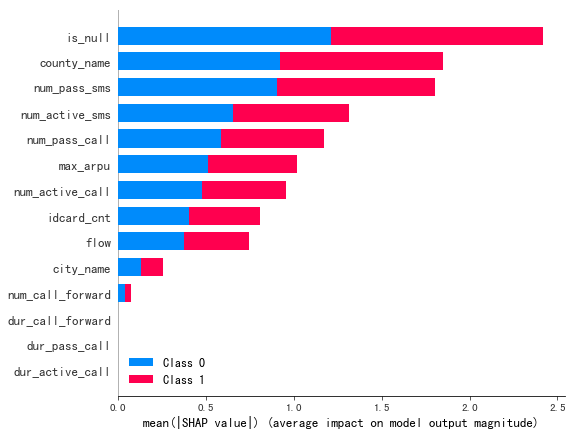

avg +++++++++++++++++++++++++++
ROC Score:  0.8682058943378929
f1-score-macro:  0.8732071987989363
tn:  1287.3333333333333
fp:  94.0
fn:  128.0
tp:  526.0
precision:  0.8483872184580871
recall:  0.8044784581860993


In [293]:
'''
    用于对比

'''
for x in combine_train.select_dtypes(include='object').columns:
    combine_train[x] = combine_train[x].astype('category')

gbm = lgb.LGBMClassifier(objective='binary',is_unbalance=True)
    
    
# X_train, X_test, y_train, y_test = train_test_split(combine_train,y,shuffle=True)

roc,f1_scoret,tnt,fpt,fnt,tpt,precisiont,recallt=0,0,0,0,0,0,0,0

kf = KFold(n_splits=5,shuffle=True)
for train_idx,test_idx in kf.split(combine_train):
    X_train,X_test = combine_train.loc[train_idx],combine_train.loc[test_idx]
    y_train,y_test = y[train_idx],y[test_idx]
    
    gbm.fit(X_train,y_train)
    y_pred = gbm.predict(X_test)
    
    
    print('---------')
    print('ROC Score: ',roc_auc_score(y_test,y_pred))
    print('f1-score-macro: ',f1_score(y_test,y_pred,average='macro'))
    
    
    
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('tn: ',tn)
    print('fp: ',fp)
    print('fn: ',fn)
    print('tp: ',tp)
    print('precision: ',tp/(tp+fp))
    print('recall: ',tp/(tp+fn))
    
    roc += roc_auc_score(y_test,y_pred)
    f1_scoret += f1_score(y_test,y_pred,average='macro')
    tnt += tn
    fpt += fp
    fnt += fn
    tpt += tp
    precisiont += tp/(tp+fp)
    recallt += tp/(tp+fn)
    
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(combine_train)
shap.summary_plot(shap_values, combine_train)
print('avg +++++++++++++++++++++++++++')
print('ROC Score: ',roc/5)
print('f1-score-macro: ',f1_scoret/5)


print('tn: ',tnt/5)
print('fp: ',fpt/5)
print('fn: ',fnt/5)
print('tp: ',tpt/5)
print('precision: ',precisiont/5)
print('recall: ',recallt/5)

In [35]:
pred = gbm.predict(combine_test)
test_user['label'] = pred

In [36]:
test_user[['phone_no_m','label']].to_csv('baseline_1.csv',index=None)